In [1]:
from dask.distributed import Client

client = Client()

# client = Client(n_workers=4)

In [2]:
from time import sleep

In [18]:
import pandas as pd
import numpy as np

In [4]:
def inc(x):
    sleep(1)
    return x + 1

In [5]:
def add(x, y):
    sleep(1)
    return x + y

# **dask.delayed (low level Dask Interface)**
1. https://docs.dask.org/en/latest/delayed.html
2. https://docs.dask.org/en/latest/delayed-best-practices.html

In [6]:
%%time

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 168 ms, sys: 18.8 ms, total: 187 ms
Wall time: 3 s


This takes three seconds to run because we call each function sequentially, one after the other

### Parallelize with the dask.delayed decorator
Those two increment calls could be called in parallel, because they are totally independent of one-another.

We'll transform the inc and add functions using the dask.delayed function. When we call the delayed version by passing the arguments, exactly as before, but the original function isn't actually called yet - which is why the cell execution finishes very quickly. Instead, a delayed object is made, which keeps track of the function to call and the arguments to pass to it.

In [7]:
from dask import delayed                # lazy computation

In [8]:
%%time

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 1.08 ms, sys: 2.1 ms, total: 3.17 ms
Wall time: 2.47 ms


This ran immediately, since nothing has really happened yet.

To get the result, call compute. Notice that this runs faster than the original code.

In [9]:
%%time

z.compute()

CPU times: user 195 ms, sys: 19.7 ms, total: 215 ms
Wall time: 2.04 s


5

#### What if we remove **sleep(1)**? Will it be even faster?

In [10]:
def inc_2(x):
    sleep(0)
    return x + 1

In [11]:
def add_2(x, y):
    sleep(0)
    return x + y

In [12]:
%%time

x_1 = delayed(inc_2)(1)
y_1 = delayed(inc_2)(2)
z_2 = delayed(add_2)(x, y)

CPU times: user 1.85 ms, sys: 0 ns, total: 1.85 ms
Wall time: 1.08 ms


In [13]:
%%time

z_2.compute()

CPU times: user 75.6 ms, sys: 13.6 ms, total: 89.2 ms
Wall time: 1.03 s


5

The z object is a *lazy delayed* object. This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another. We can evaluate the result with .compute() as above or we can visualize the task graph for this value with .visualize().

In [14]:
z

Delayed('add-aa49dfda-e26d-459e-bc56-48ec2fe1bc09')

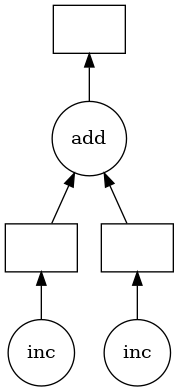

In [15]:
z.visualize()                      # task graph

#### ex1:

In [16]:
data = [1, 2, 3, 4, 5, 6, 7, 8]
data

[1, 2, 3, 4, 5, 6, 7, 8]

In [17]:
%%time
# sequential coding to get the sum

results = []

for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

print(total)

44
CPU times: user 605 ms, sys: 88 ms, total: 693 ms
Wall time: 8.01 s


In [18]:
%%time
# parallel coding to get the sum

results = []

for x in data:
    y_2 = delayed(inc)(x)
    results.append(y_2)
    
total_2 = delayed(sum)(results)
print(f"Before computing: {total_2}")

total_2_result = total_2.compute()
print(f"After computing: {total_2_result}")

Before computing: Delayed('sum-b47c6109-1305-4063-ad13-aa9c0a286aea')
After computing: 44
CPU times: user 203 ms, sys: 20.8 ms, total: 224 ms
Wall time: 2.04 s


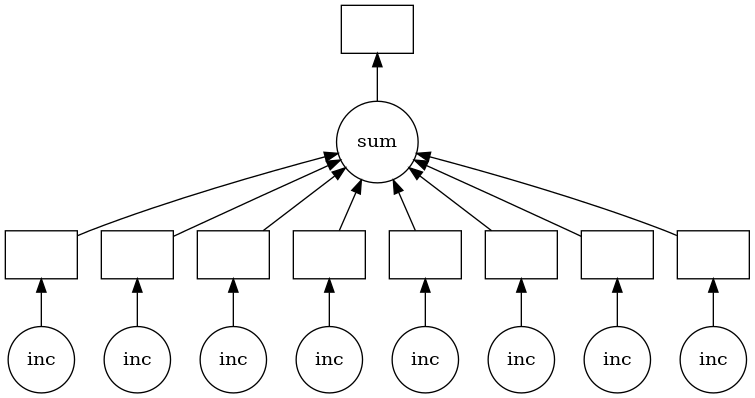

In [19]:
delayed(sum)(results).visualize()                    # paralleled

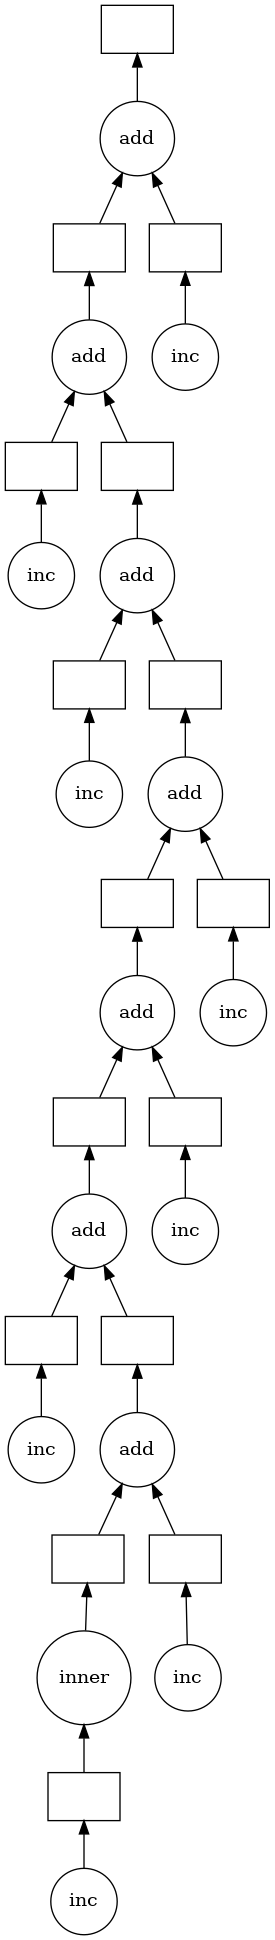

In [20]:
sum(results).visualize()                            # sequentially 

#### adding 2 delayed obj together:

In [21]:
delayed(inc)(1) + delayed(inc)(2)

Delayed('add-b15f2cf66010ce996fd3fac91ec118e8')

In [22]:
(delayed(inc)(1) + delayed(inc)(2)).compute()

5

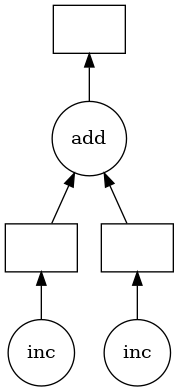

In [23]:
(delayed(inc)(1) + delayed(inc)(2)).visualize()

#### ex2:

In [24]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

In [25]:
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [26]:
%%time
# sequential code to get the sum:

results = []

for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 778 ms, sys: 125 ms, total: 902 ms
Wall time: 10 s


In [27]:
%%time
# parallel streamline:

results = []

for x in data:
    if is_even(x): 
        y = delayed(double)(x)
    else:          
        y = delayed(inc)(x)
    results.append(y)
    
total_2 = delayed(sum)(results)
print(total_2)

Delayed('sum-516fb5a4-f9be-44e7-9b87-acf4f629e7f8')
CPU times: user 9.22 ms, sys: 1.33 ms, total: 10.5 ms
Wall time: 8.83 ms


In [28]:
%time 

total_2.compute()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


90

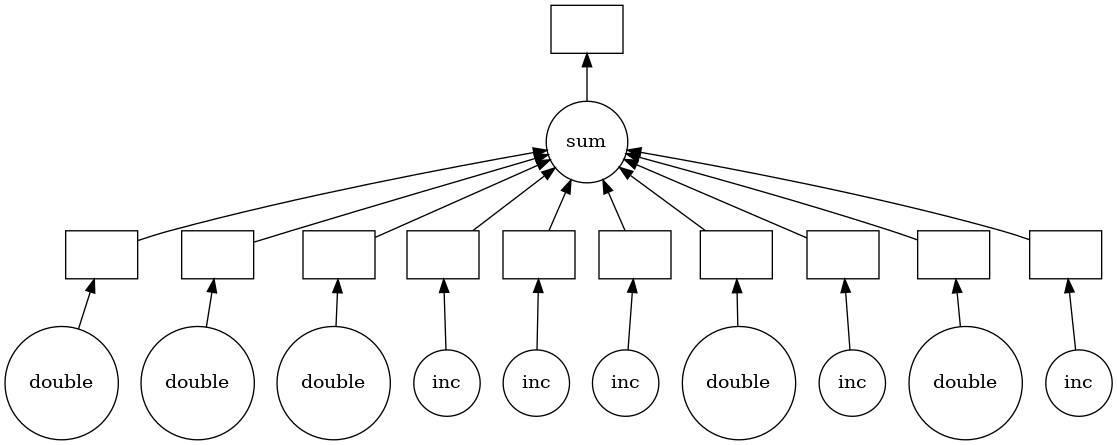

In [29]:
total_2.visualize()

Note:
1. You cannot delay a bool type evaluation cuz it demands the final result of the boolean value, which in turn will contribute to the next step

#### **Real Data**

In [31]:
%run prep.py -d flights

- Downloading NYC Flights dataset... done
- Extracting flight data... done
- Creating json data... done
** Created flights dataset! in 6.98s**


In [32]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

#### one year data:

In [33]:
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head(3)

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  1990      1           1          1   1621.0        1540   1747.0   
1  1990      1           2          2   1547.0        1540   1700.0   
2  1990      1           3          3   1546.0        1540   1710.0   

   CRSArrTime UniqueCarrier  FlightNum  ...  AirTime  ArrDelay  DepDelay  \
0        1701            US         33  ...      NaN      46.0      41.0   
1        1701            US         33  ...      NaN      -1.0       7.0   
2        1701            US         33  ...      NaN       9.0       6.0   

   Origin  Dest  Distance TaxiIn TaxiOut  Cancelled  Diverted  
0     EWR   PIT     319.0    NaN     NaN          0         0  
1     EWR   PIT     319.0    NaN     NaN          0         0  
2     EWR   PIT     319.0    NaN     NaN          0         0  

[3 rows x 23 columns]

In [34]:
df.shape

(999, 23)

In [35]:
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'Diverted'],
      dtype='object')

In [37]:
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [38]:
df['Origin'].unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [42]:
df.groupby('Origin')['DepDelay'].mean()

Origin
EWR    10.854962
JFK    17.027397
LGA    10.895592
Name: DepDelay, dtype: float64

#### multiple yrs:
what if we wanna compute all yr's DepDelay mean time?

In [43]:
from glob import glob

filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [64]:
%%time

# sequential flow to iterate over each yr and compute:

sums = []
counts = []

for fn in filenames:

    df = pd.read_csv(fn)
    
    by_origin = df.groupby('Origin')
    
    total = by_origin.DepDelay.sum()
    
    count = by_origin.DepDelay.count()
    
    sums.append(total)
    
    counts.append(count)

total_delays = sum(sums)

n_flights = sum(counts)

mean = total_delays / n_flights

CPU times: user 70.8 ms, sys: 505 µs, total: 71.3 ms
Wall time: 71.3 ms


In [63]:
mean                                   # the NaNs for JFK is possibly due to Binder space limit, so not all data load in

Origin
EWR    12.500968
JFK          NaN
LGA    10.169227
Name: DepDelay, dtype: float64

#### parallelizing:

Use `dask.delayed` to parallelize, some extra things you will need to know:

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> from dask import compute
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`, x**2 only compute once, not twice)

In [29]:
from dask import compute

In [ ]:
%%time

sums = []
counts = []

for fn in filenames:
    
    df = delayed(pd.read_csv)(fn)
    
    by_origin = df.groupby('Origin')

    total = by_origin.DepDelay.sum()

    count = by_origin.DepDelay.count()

    sums.append(total)
    counts.append(count)

sums, counts = compute(sums, counts)

total_delays = sum(sums)

n_flights = sum(counts)

mean = total_delays / n_flights

In [ ]:
mean

# **Dask Arrays (high-level Dask interface)**
1. **distributed NumPy**
2. **Parallel**: Uses all of the cores on your computer
3. **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
4. **Blocked Algorithms**:  Perform large computations by performing many smaller computations

In [1]:
%run prep.py -d random

Created random data for array exercise in 1.07s


In [2]:
from dask.distributed import Client

client = Client(n_workers=4)

In [3]:
# Load data with h5py
# this creates a pointer to the data, but does not actually load
import h5py
import os
f = h5py.File(os.path.join('data', 'random.hdf5'), mode='r')
dset = f['/x']

In [4]:
# compute sum of large array, one million numbers at a time:

sums = []

for i in range(0, 1000000000, 1000000):
    
    chunk = dset[i: i + 1000000]
    
    sums.append(chunk.sum())

total = sum(sums)

print(total)

4996340.5625


In [5]:
sums = []
lengths = []

for i in range(0, 1000000000, 1000000):
    
    chunk = dset[i: i + 1000000]
    
    sums.append(chunk.sum())
    
    lengths.append(len(chunk))

total = sum(sums)

length = sum(lengths)

print(total / length)

0.9992681125


#### now moving to dask.array:

You can create a `dask.array` `Array` object with the `da.from_array` function.  This function accepts

1.  `data`: Any object that supports NumPy slicing, like `dset`
2.  `chunks`: A chunk size to tell us how to block up our array, like `(1000000,)`

In [2]:
import dask.array as da

In [8]:
x = da.from_array(dset, chunks=(1000000,))                  # it's just a pointer, not doing calcaulations yet
x

dask.array<array, shape=(5000000,), dtype=float32, chunksize=(1000000,), chunktype=numpy.ndarray>

In [9]:
result = x.sum()                                            # still a pointer, not doing calcaulations
result

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [10]:
result.compute()

4996340.5

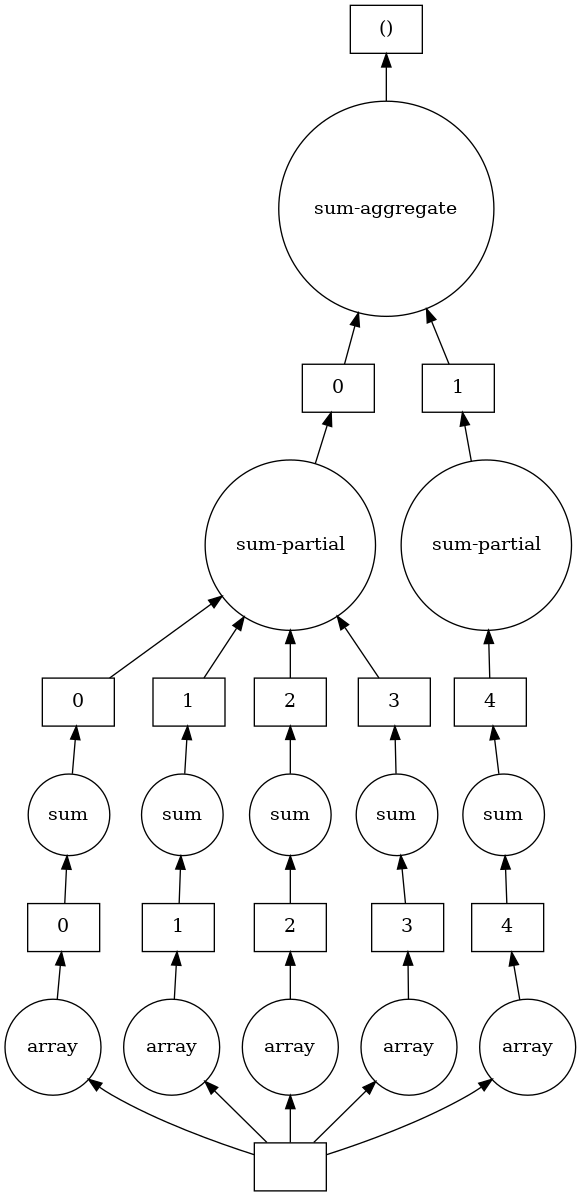

In [11]:
result.visualize()

In [12]:
x.mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [13]:
x.mean().compute()

0.9992681

In [16]:
type(x)

dask.array.core.Array

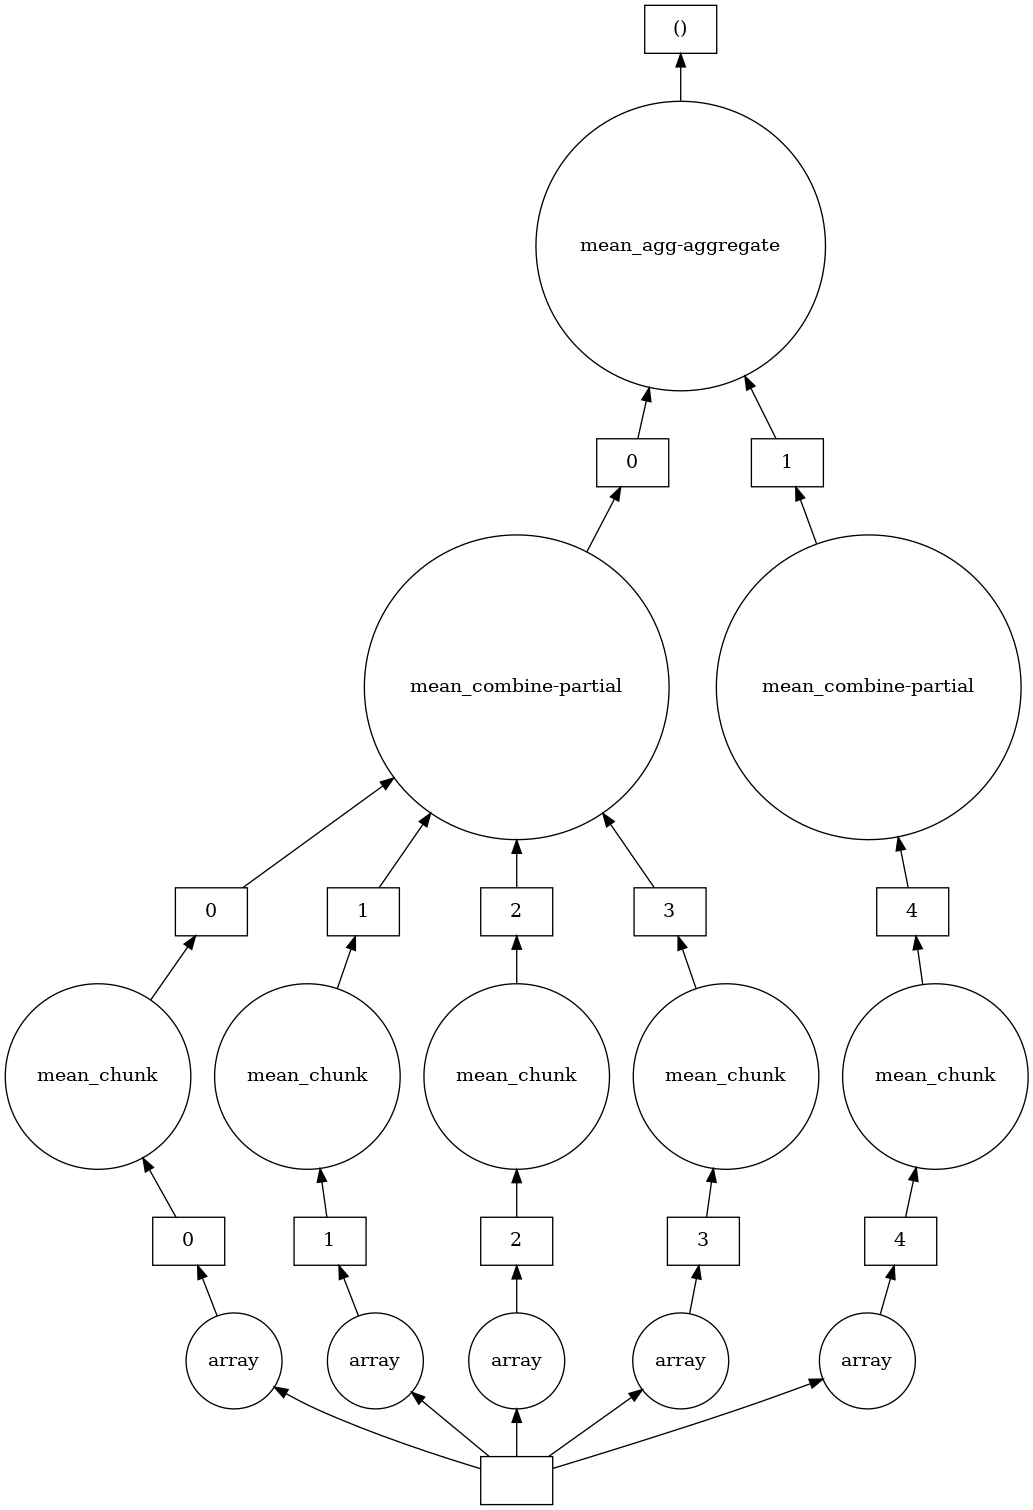

In [17]:
x.mean().visualize()

#### ex1:

1.  Construct a 20000x20000 array of normally distributed random values broken up into 1000x1000 sized chunks
2.  Take the mean along one axis
3.  Take every 100th element

In [19]:
x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array 
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::100]                            # Perform NumPy-style operations

In [20]:
x

dask.array<normal, shape=(20000, 20000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [21]:
y

dask.array<getitem, shape=(200,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.391388 to fit


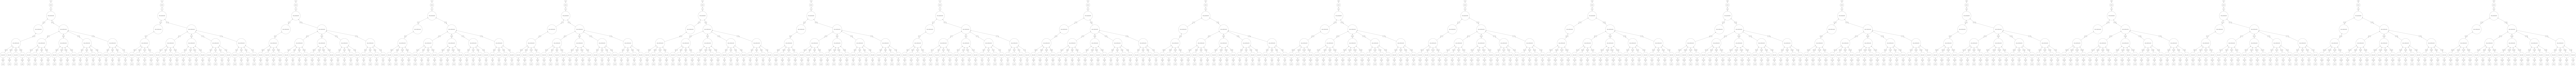

In [25]:
y.visualize()

In [27]:
x.nbytes / 1e9                    # gigabytes of the input processed lazily

3.2

In [28]:
%%time
y.compute()

CPU times: user 3.76 s, sys: 378 ms, total: 4.13 s
Wall time: 39 s


array([ 9.99917948, 10.00041479,  9.99999711, 10.00032798, 10.00055026,
        9.99968018, 10.00090618,  9.99934292,  9.99979426,  9.99922161,
        9.99986978,  9.99970947, 10.00066125,  9.99989209,  9.99913959,
        9.99969326, 10.00070212,  9.99977154, 10.00010955, 10.00008921,
        9.99965706,  9.99954458, 10.0015686 , 10.00099767, 10.00097792,
        9.99912451,  9.99831648, 10.0001203 ,  9.99997682,  9.99967979,
       10.0004761 , 10.00031243, 10.00078759, 10.0000012 , 10.00029539,
        9.99931652, 10.00027841,  9.9998515 , 10.00078448,  9.99970664,
        9.99977032, 10.00149769,  9.99884403, 10.00108961, 10.00199144,
        9.99955031,  9.99939886,  9.99991319, 10.00055942, 10.00103552,
        9.99986493, 10.0001005 , 10.00016854, 10.00009417,  9.99897489,
        9.99984664, 10.00070753,  9.99999819, 10.00009795, 10.00039581,
        9.99999538,  9.99965619, 10.00048273, 10.00039809, 10.00116657,
        9.99955042, 10.00067222,  9.99981076,  9.99930177, 10.00

#### Performance comparision
---------------------------

The following experiment was performed on a heavy personal laptop.  Your performance may vary.  If you attempt the NumPy version then please ensure that you have more than 4GB of main memory.

**NumPy: 19s, Needs gigabytes of memory:**

In [ ]:
%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distribu

**Dask Array: 4s, Needs megabytes of memory:**

In [3]:
%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 25.7 s, sys: 256 ms, total: 26 s
Wall time: 28.8 s


array([ 9.99984836,  9.99959348, 10.00084998,  9.99981167,  9.99918451,
       10.0015013 ,  9.99968663,  9.99879111, 10.00068019, 10.00123668,
       10.00113097,  9.99886795, 10.00033263,  9.99861503, 10.00023928,
        9.99990492,  9.99911745, 10.00002896,  9.99963317,  9.99933821,
        9.99876611, 10.00032284, 10.0006077 , 10.00021267,  9.99999204,
        9.9991074 , 10.00141073, 10.00014715,  9.99993578, 10.0011766 ,
        9.99935871,  9.99952352, 10.00055638,  9.99973334, 10.00105568,
       10.00148075, 10.00013453, 10.00016955,  9.9993875 , 10.00016103,
        9.99875996, 10.00158803,  9.99932344, 10.00019667, 10.00048725,
       10.0006392 ,  9.9998377 ,  9.99992363, 10.00019999, 10.00056173,
        9.9995003 ,  9.99928213, 10.00017934,  9.99981093, 10.00024839,
        9.99841037, 10.00047586, 10.00058857, 10.00022252,  9.99974118,
        9.99981345, 10.0007424 , 10.00013278,  9.99940245, 10.00126874,
        9.99950416, 10.00045779,  9.99985074,  9.99967344,  9.99

#### ex2:

In [4]:
%run prep.py -d weather

Created weather dataset in 0.29s


In [13]:
!du -h data/weather-big/

16M	data/weather-big/


In [5]:
import h5py
from glob import glob
import os

In [6]:
filenames = sorted(glob(os.path.join('data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]
dsets[0]

<HDF5 dataset "t2m": shape (180, 360), type "<f8">

In [8]:
len(dsets)

31

In [9]:
dsets

[<HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "<f8">,
 <HDF5 dataset "t2m": shape (180, 360), type "

In [10]:
dsets[0]

<HDF5 dataset "t2m": shape (180, 360), type "<f8">

In [11]:
dsets[0][:5, :5]

array([[84.75, 84.75, 84.75, 84.75, 84.75],
       [83.  , 83.  , 83.  , 83.  , 83.  ],
       [84.5 , 84.  , 84.  , 84.  , 84.  ],
       [81.25, 81.25, 81.25, 81.25, 81.25],
       [77.75, 77.75, 77.75, 77.75, 77.75]])

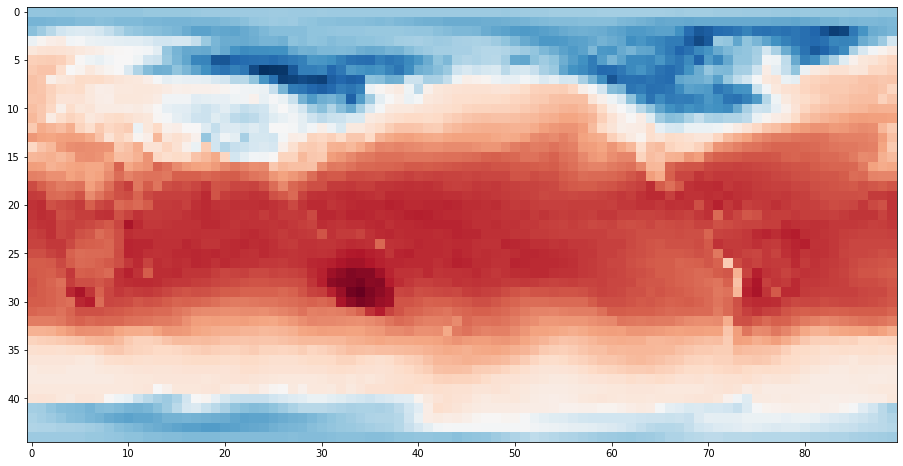

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16, 8))
plt.imshow(dsets[0][::4, ::4], cmap='RdBu_r')
plt.show()

**now integrate with dask.array:**

In [20]:
arrays = [da.from_array(dset, chunks=(50, 100)) for dset in dsets]
arrays

[dask.array<array, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>,
 dask.array<array, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>,
 dask.array<array, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>,
 dask.array<array, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>,
 dask.array<array, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>,
 dask.array<array, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>,
 dask.array<array, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>,
 dask.array<array, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>,
 dask.array<array, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>,
 dask.array<array, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>,
 dask.arra

In [24]:
arrays[0]

dask.array<array, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>

**Stack this list of `dask.array` objects into a single `dask.array` object with `da.stack`:**

In [21]:
x = da.stack(arrays, axis=0)
x

dask.array<stack, shape=(31, 180, 360), dtype=float64, chunksize=(1, 50, 100), chunktype=numpy.ndarray>

In [25]:
x.shape

(31, 180, 360)

In [27]:
result = x.mean(axis=0) 
result

dask.array<mean_agg-aggregate, shape=(180, 360), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>

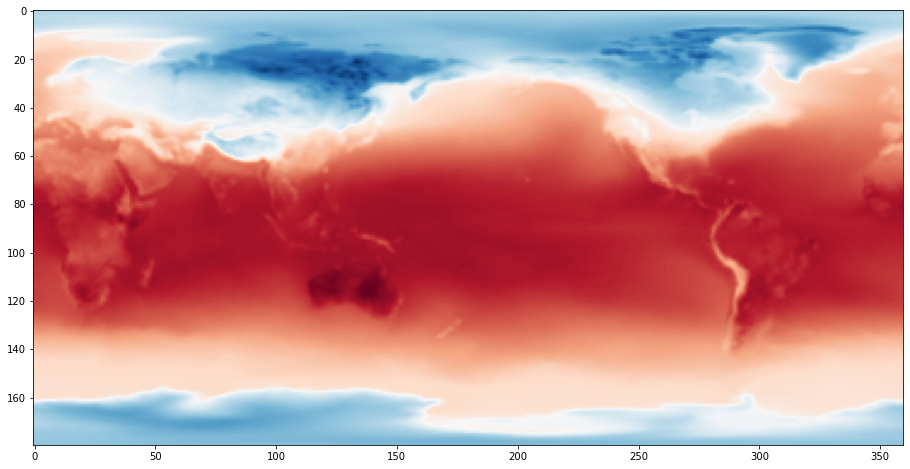

In [22]:
result = x.mean(axis=0)                              # result is still a lazy computation, but when it feeds into imshow, it autimatically computed
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r')
plt.show()

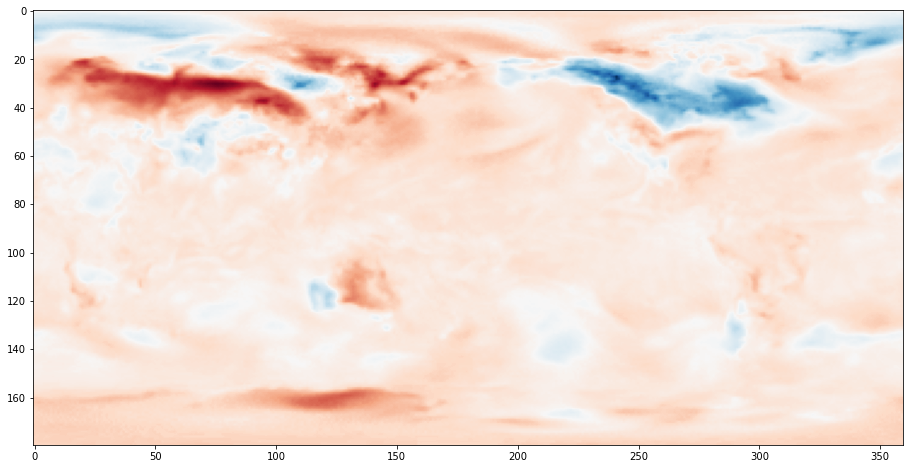

In [23]:
result = x[0] - x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r')
plt.show()

#### **storage:**

In the above exercise the result of our computation is small, so we can call `compute` safely.  Sometimes our result is still too large to fit into memory and we want to save it to disk.  In these cases you can use one of the following two functions

1.  `da.store`: Store dask.array into any object that supports numpy setitem syntax, e.g.

        f = h5py.File('myfile.hdf5')
        output = f.create_dataset(shape=..., dtype=...)
        
        da.store(my_dask_array, output)
        
2.  `da.to_hdf5`: A specialized function that creates and stores a `dask.array` object into an `HDF5` file.

        da.to_hdf5('data/myfile.hdf5', '/output', my_dask_array)

In [29]:
import h5py
from glob import glob
import os
import dask.array as da

filenames = sorted(glob(os.path.join('data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]

arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]

x = da.stack(arrays, axis=0)

result = x[:, ::2, ::2]

da.to_zarr(result, os.path.join('data', 'myfile.zarr'), overwrite=True)      # zarr is a newly developed HDFS-wise system, the advantage over HDFS is that you can reach a piece of info of the metadata, while HDFS can only be read as a single whole file with everything sticked to it

Limitations
-----------

Dask Array does not implement the entire numpy interface.  Users expecting this
will be disappointed.  Notably Dask Array has the following failings:

1.  Dask does not implement all of ``np.linalg``.  This has been done by a
    number of excellent BLAS/LAPACK implementations and is the focus of
    numerous ongoing academic research projects.
2.  Dask Array does not support some operations where the resulting shape
    depends on the values of the array. For those that it does support
    (for example, masking one Dask Array with another boolean mask),
    the chunk sizes will be unknown, which may cause issues with other
    operations that need to know the chunk sizes.
3.  Dask Array does not attempt operations like ``sort`` which are notoriously
    difficult to do in parallel and are of somewhat diminished value on very
    large data (you rarely actually need a full sort).
    Often we include parallel-friendly alternatives like ``topk``.
4.  Dask development is driven by immediate need, and so many lesser used
    functions, like ``np.sometrue`` have not been implemented purely out of
    laziness.  These would make excellent community contributions.
    
* [Array documentation](https://docs.dask.org/en/latest/array.html)
* [Array screencast](https://youtu.be/9h_61hXCDuI)
* [Array API](https://docs.dask.org/en/latest/array-api.html)
* [Array examples](https://examples.dask.org/array.html)

# **Dask DataFrame (high-level Dask interface)**

## When to use `dask.dataframe`

Pandas is great for tabular datasets that fit in memory. Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM. The demo dataset we're working with is only about 200MB, so that you can download it in a reasonable time, but `dask.dataframe` will scale to  datasets much larger than memory.

The `dask.dataframe` module implements a blocked parallel `DataFrame` object that mimics a large subset of the Pandas `DataFrame`. One Dask `DataFrame` is comprised of many in-memory pandas `DataFrames` separated along the index. One operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.

**Related Documentation**

* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

**Main Take-aways**

1.  Dask DataFrame should be familiar to Pandas users
2.  The partitioning of dataframes is important for efficient execution

In [2]:
%run prep.py -d flights

- Downloading NYC Flights dataset... done
- Extracting flight data... done
- Creating json data... done
** Created flights dataset! in 5.92s**


In [3]:
from dask.distributed import Client

client = Client(n_workers=4)

/srv/conda/envs/notebook/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33755 instead
  warnings.warn(


In [4]:
from prep import accounts_csvs

accounts_csvs()

import os
import dask
filename = os.path.join('data', 'accounts.*.csv')
filename

Created CSV acccouts in 0.07s


'data/accounts.*.csv'

In [5]:
import dask.dataframe as dd

In [6]:
df = dd.read_csv(filename)
df.head()

id    names  amount
0  61  Norbert    7404
1  33      Dan     871
2  64   Ursula      43
3  49    Laura   10130
4  60    Jerry     541

In [7]:
len(df)

30000

In [8]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

In [9]:
df

Dask DataFrame Structure:
                          Date DayOfWeek  DepTime CRSDepTime  ArrTime CRSArrTime UniqueCarrier FlightNum  TailNum ActualElapsedTime CRSElapsedTime  AirTime ArrDelay DepDelay  Origin    Dest Distance   TaxiIn  TaxiOut Cancelled Diverted
npartitions=10                                                                                                                                                                                                                             
                datetime64[ns]     int64  float64      int64  float64      int64        object     int64  float64           float64          int64  float64  float64  float64  object  object  float64  float64  float64     int64    int64
                           ...       ...      ...        ...      ...        ...           ...       ...      ...               ...            ...      ...      ...      ...     ...     ...      ...      ...      ...       ...      ...
...                        ...       ...      ...        ...      ...        ...           ...       ...      ...               ...            ...      ...      ...      ...     ...     ...      ...      ...      ...       ...      ...
                           ...       ...      ...        ...      ...        ...           ...       ...      ...               ...            ...      ...      ...      ...     ...     ...      ...      ...      ...       ...      ...
                           ...       ...      ...        ...      ...        ...           ...       ...      ...               ...            ...      ...      ...      ...     ...     ...      ...      ...      ...       ...      ...
Dask Name: read-csv, 10 tasks

In [10]:
type(df)

dask.dataframe.core.DataFrame

In [11]:
df.head(3)

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
0 1990-01-01          1   1621.0        1540   1747.0        1701   
1 1990-01-02          2   1547.0        1540   1700.0        1701   
2 1990-01-03          3   1546.0        1540   1710.0        1701   

  UniqueCarrier  FlightNum  TailNum  ActualElapsedTime  ...  AirTime  \
0            US         33      NaN               86.0  ...      NaN   
1            US         33      NaN               73.0  ...      NaN   
2            US         33      NaN               84.0  ...      NaN   

   ArrDelay  DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  \
0      46.0      41.0     EWR  PIT    319.0     NaN      NaN          0   
1      -1.0       7.0     EWR  PIT    319.0     NaN      NaN          0   
2       9.0       6.0     EWR  PIT    319.0     NaN      NaN          0   

   Diverted  
0         0  
1         0  
2         0  

[3 rows x 21 columns]

#### pd VS da:

In [12]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),            # explicit designate the data types
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [13]:
df

Dask DataFrame Structure:
                          Date DayOfWeek  DepTime CRSDepTime  ArrTime CRSArrTime UniqueCarrier FlightNum TailNum ActualElapsedTime CRSElapsedTime  AirTime ArrDelay DepDelay  Origin    Dest Distance   TaxiIn  TaxiOut Cancelled Diverted
npartitions=10                                                                                                                                                                                                                            
                datetime64[ns]     int64  float64      int64  float64      int64        object     int64  object           float64        float64  float64  float64  float64  object  object  float64  float64  float64      bool    int64
                           ...       ...      ...        ...      ...        ...           ...       ...     ...               ...            ...      ...      ...      ...     ...     ...      ...      ...      ...       ...      ...
...                        ...       ...      ...        ...      ...        ...           ...       ...     ...               ...            ...      ...      ...      ...     ...     ...      ...      ...      ...       ...      ...
                           ...       ...      ...        ...      ...        ...           ...       ...     ...               ...            ...      ...      ...      ...     ...     ...      ...      ...      ...       ...      ...
                           ...       ...      ...        ...      ...        ...           ...       ...     ...               ...            ...      ...      ...      ...     ...     ...      ...      ...      ...       ...      ...
Dask Name: read-csv, 10 tasks

In [14]:
%time

df.DepDelay.max().compute()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.68 µs


409.0

In [15]:
df.tail(3)  # now works

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
996 1999-01-27          3    631.0         635    756.0         817   
997 1999-01-28          4    629.0         635    803.0         817   
998 1999-01-29          5    632.0         635    802.0         817   

    UniqueCarrier  FlightNum TailNum  ActualElapsedTime  ...  AirTime  \
996            CO        437  N12216               85.0  ...     66.0   
997            CO        437  N26210               94.0  ...     69.0   
998            CO        437  N12225               90.0  ...     67.0   

     ArrDelay  DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  \
996     -21.0      -4.0     EWR  RDU    416.0     4.0     15.0      False   
997     -14.0      -6.0     EWR  RDU    416.0     5.0     20.0      False   
998     -15.0      -3.0     EWR  RDU    416.0     5.0     18.0      False   

     Diverted  
996         0  
997         0  
998         0  

[3 rows x 21 columns]

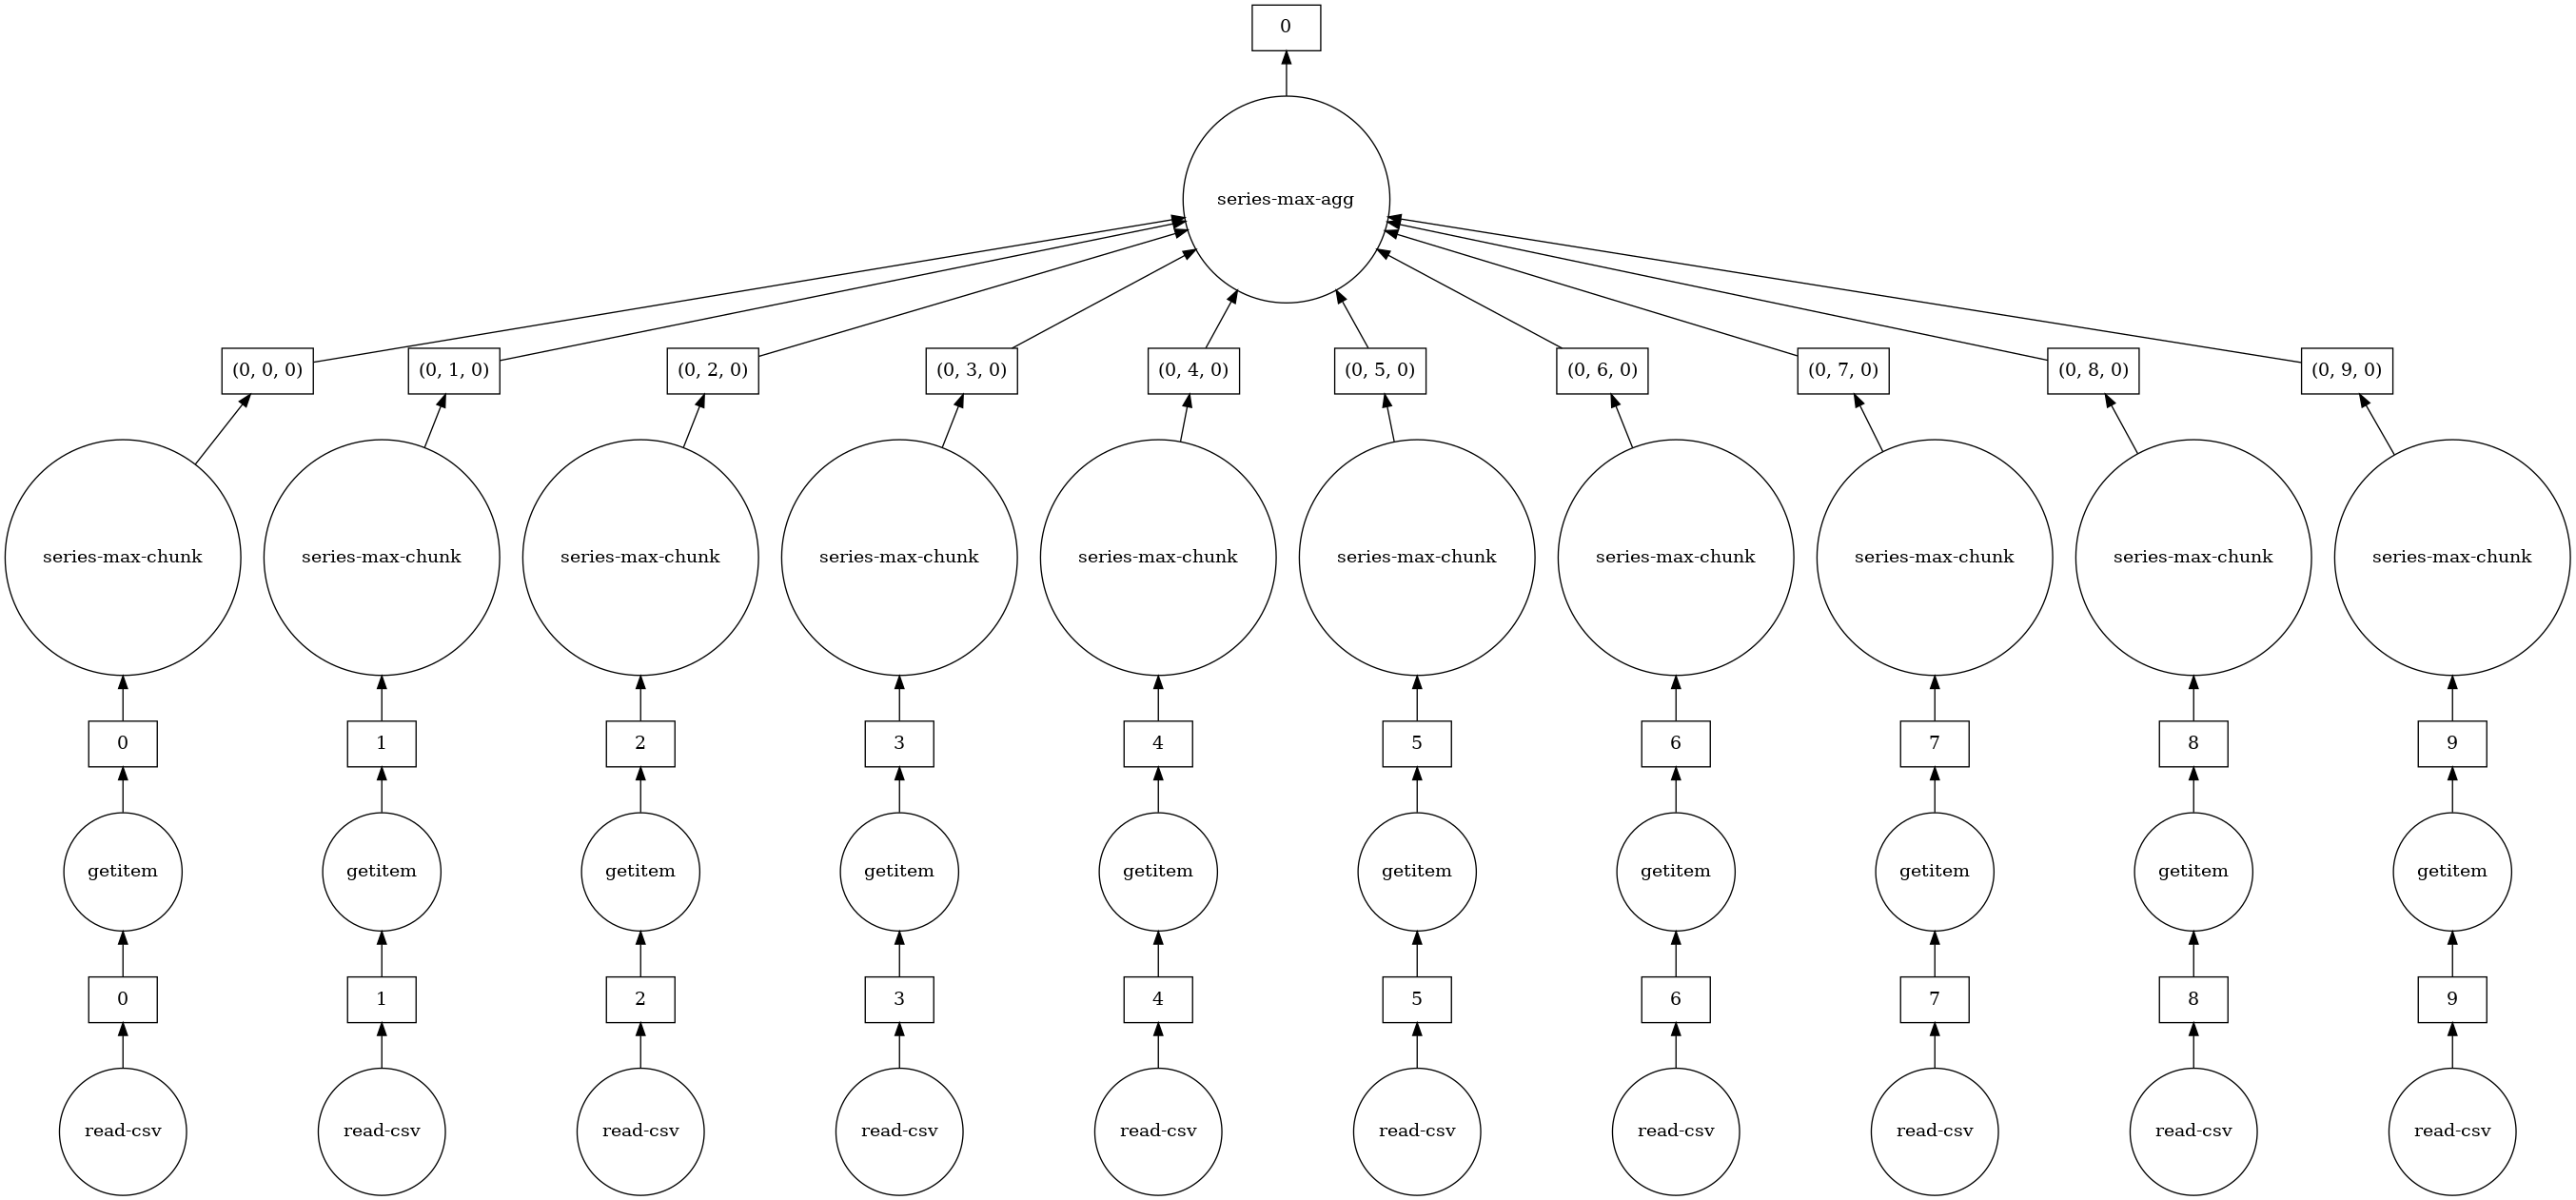

In [16]:
df.DepDelay.max().visualize()

In [17]:
df.shape

(Delayed('int-93d2827c-3bbb-4583-bc8f-87fc3652efa8'), 21)

In [18]:
df.shape[0]

Delayed('int-200a8801-9c9a-45f9-8031-5651e5308b33')

In [19]:
df.shape[0].compute()

9990

In [20]:
len(df)

9990

In [21]:
df.columns

Index(['Date', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted'],
      dtype='object')

In [22]:
In total, how many non-canceled flights were taken?

Object `taken` not found.


In [25]:
non_cancelled = df[~df.Cancelled]                        # ~ is the opposite of boolean we got
len(non_cancelled)

9383

In [26]:
mean_delay = non_cancelled.DepDelay.mean()

std_delay = non_cancelled.DepDelay.std()

In [30]:
compute(mean_delay, std_delay)

(11.992113396568262, 30.171133816160243)

In [31]:
df[~df.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    4132
JFK    1085
LGA    4166
Name: Origin, dtype: int64

In [32]:
df.groupby("Origin")['DepDelay'].mean().compute()

Origin
EWR    12.500968
JFK    17.053456
LGA    10.169227
Name: DepDelay, dtype: float64

In [33]:
df.groupby("DayOfWeek").DepDelay.mean().compute()

DayOfWeek
1    10.677698
2     8.633310
3    14.208160
4    14.187853
5    15.209929
6     9.540307
7    10.609375
Name: DepDelay, dtype: float64

#### sharing intermediate results:

In [38]:
%%time

mean_delay_1 = mean_delay.compute()
std_delay_1 = std_delay.compute()

CPU times: user 113 ms, sys: 14.9 ms, total: 128 ms
Wall time: 600 ms


In [39]:
%%time

mean_delay_2, std_delay_2 = dask.compute(mean_delay, std_delay)

CPU times: user 81.5 ms, sys: 16.3 ms, total: 97.8 ms
Wall time: 400 ms


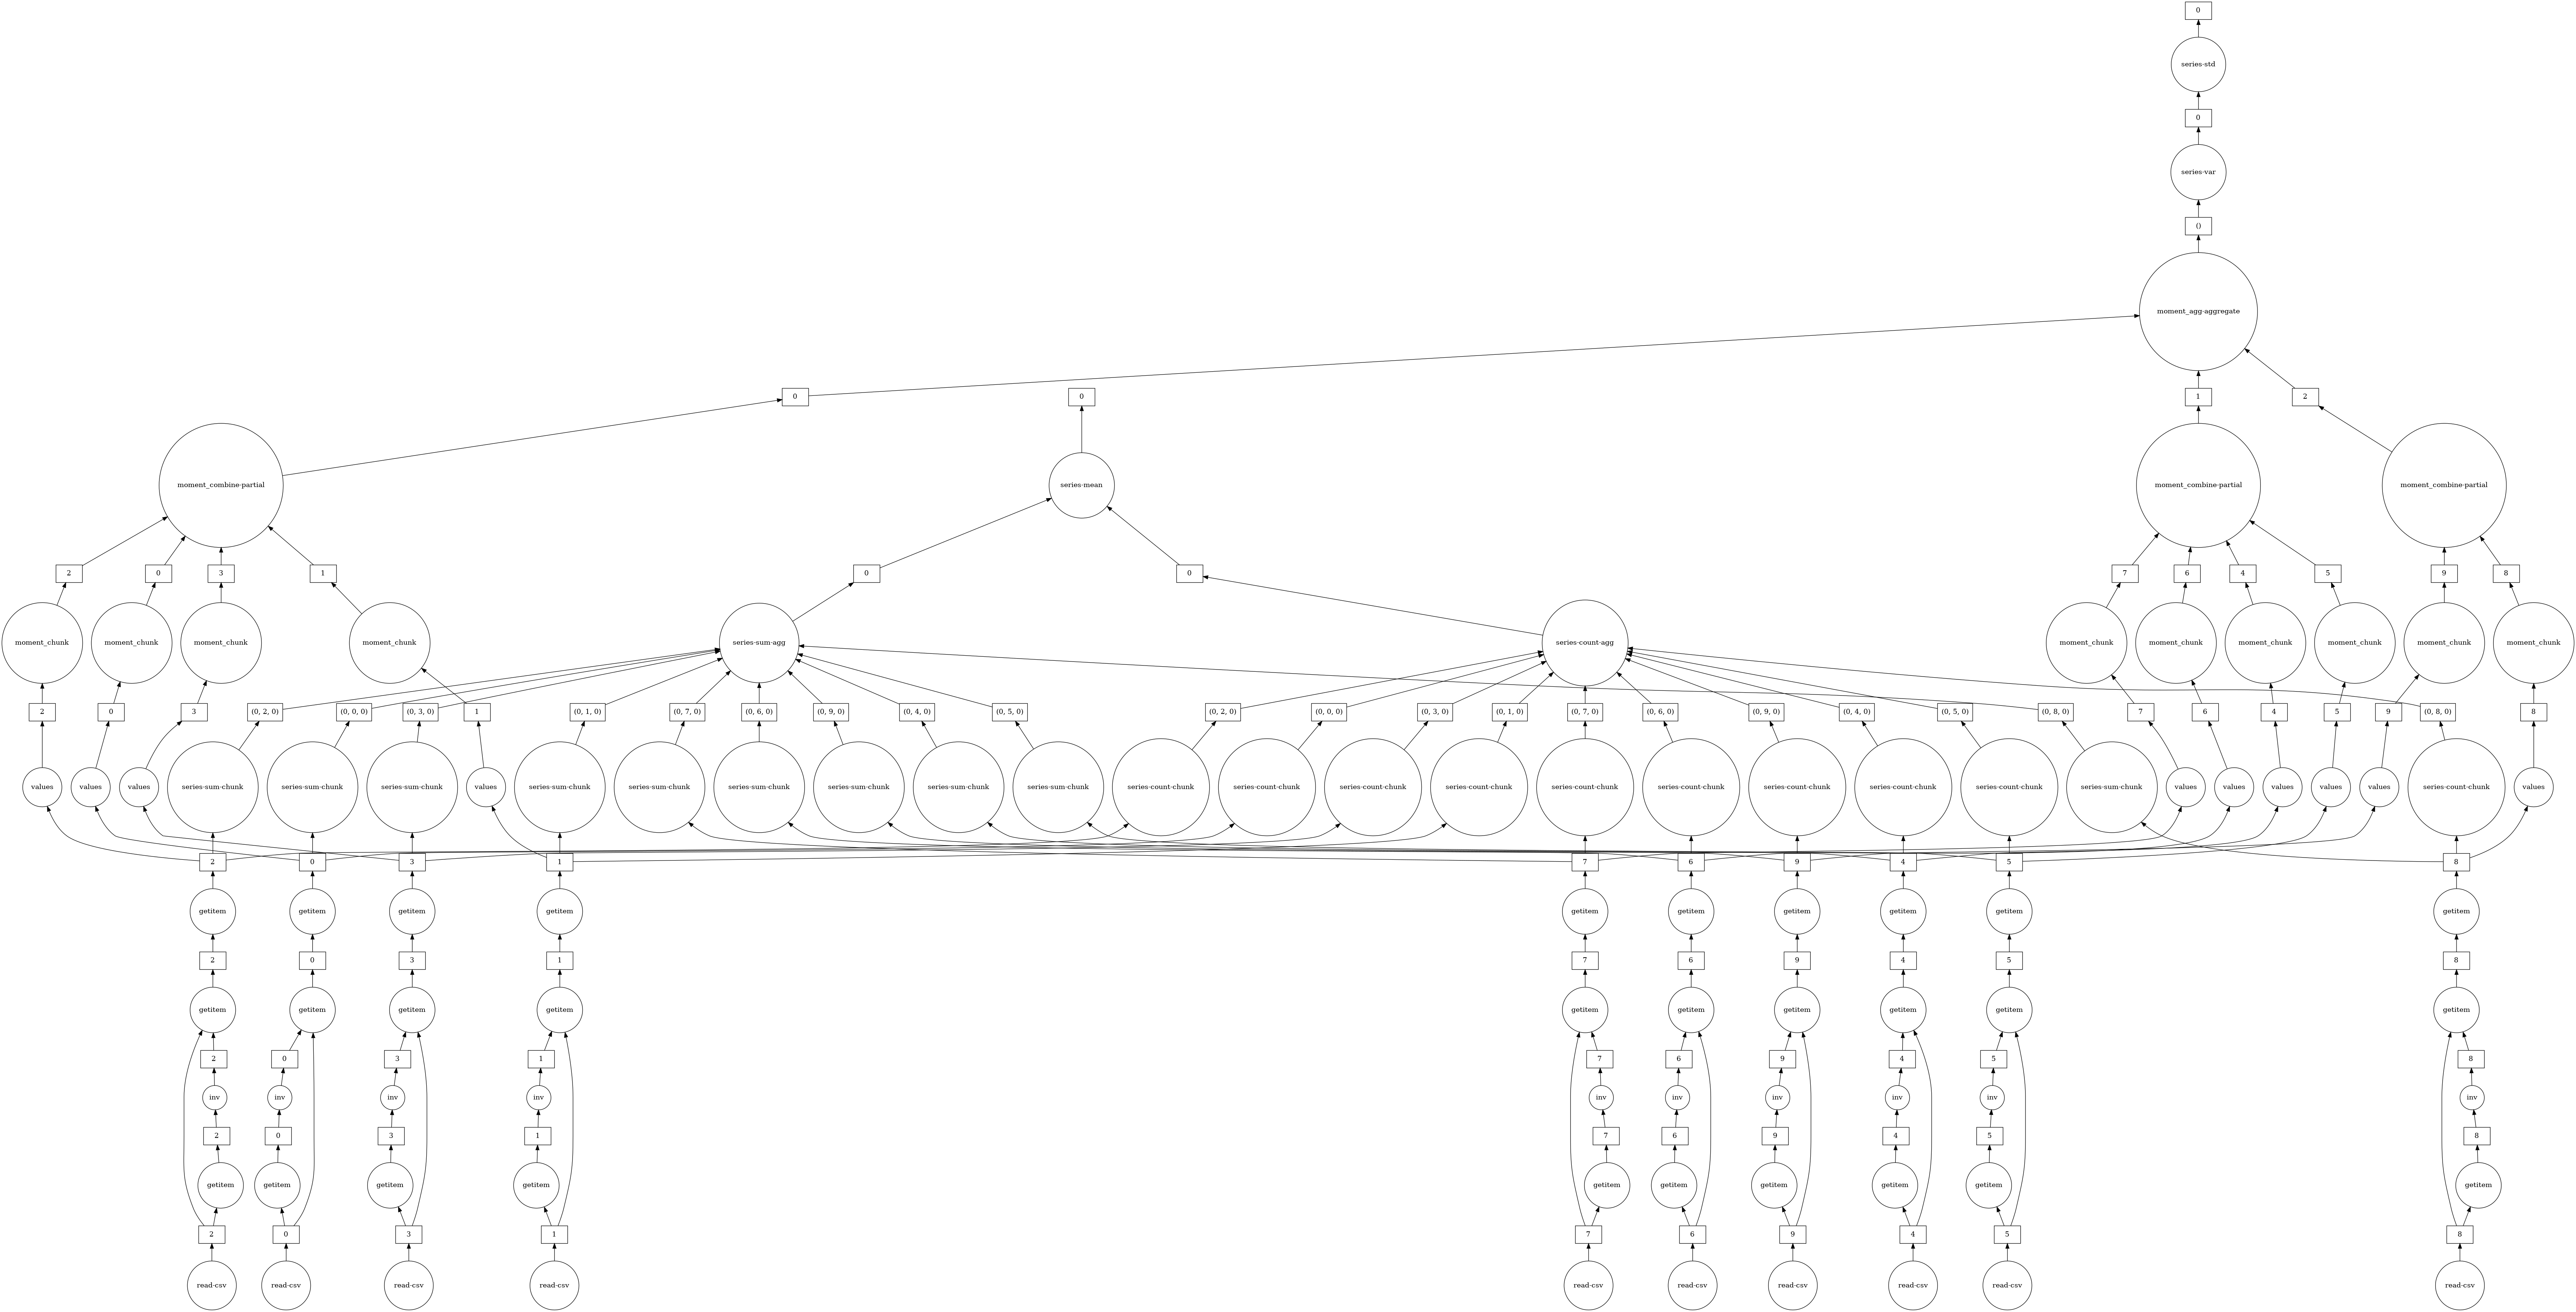

In [43]:
dask.visualize(mean_delay, std_delay)

Side tip: parquet is surpior than csv in that it can be load only interested columns, while you have to load all columns as an entire file if it is a csv file

# **Distributed Schedulers**

Dask comes with four available distributed schedulers:
- "threaded": a scheduler backed by a thread pool
- "processes": a scheduler backed by a process pool
- "single-threaded" (aka "sync"): a synchronous scheduler, good for debugging
- distributed: a distributed scheduler for executing graphs on multiple machines, see below.

To select one of these for computation, you can specify at the time of asking for a result, e.g.,
```python
myvalue.compute(scheduler="single-threaded")  # for debugging
```

In [1]:
%run prep.py -d flights

In [2]:
import dask.dataframe as dd
import os
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': object,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

# Maximum average non-cancelled delay grouped by Airport
largest_delay = df[~df.Cancelled].groupby('Origin').DepDelay.mean().max()
largest_delay

dd.Scalar<series-..., dtype=float64>

In [3]:
# each of the following gives the same results (you can check!)
# any surprises?
import time
for sch in ['threading', 'processes', 'sync']:
    t0 = time.time()
    r = largest_delay.compute(scheduler=sch)
    t1 = time.time()
    print(f"{sch:>10}, {t1 - t0:0.4f} s; result, {r:0.2f} hours")

 threading, 0.2503 s; result, 17.05 hours
 processes, 1.6909 s; result, 17.05 hours
      sync, 0.1951 s; result, 17.05 hours


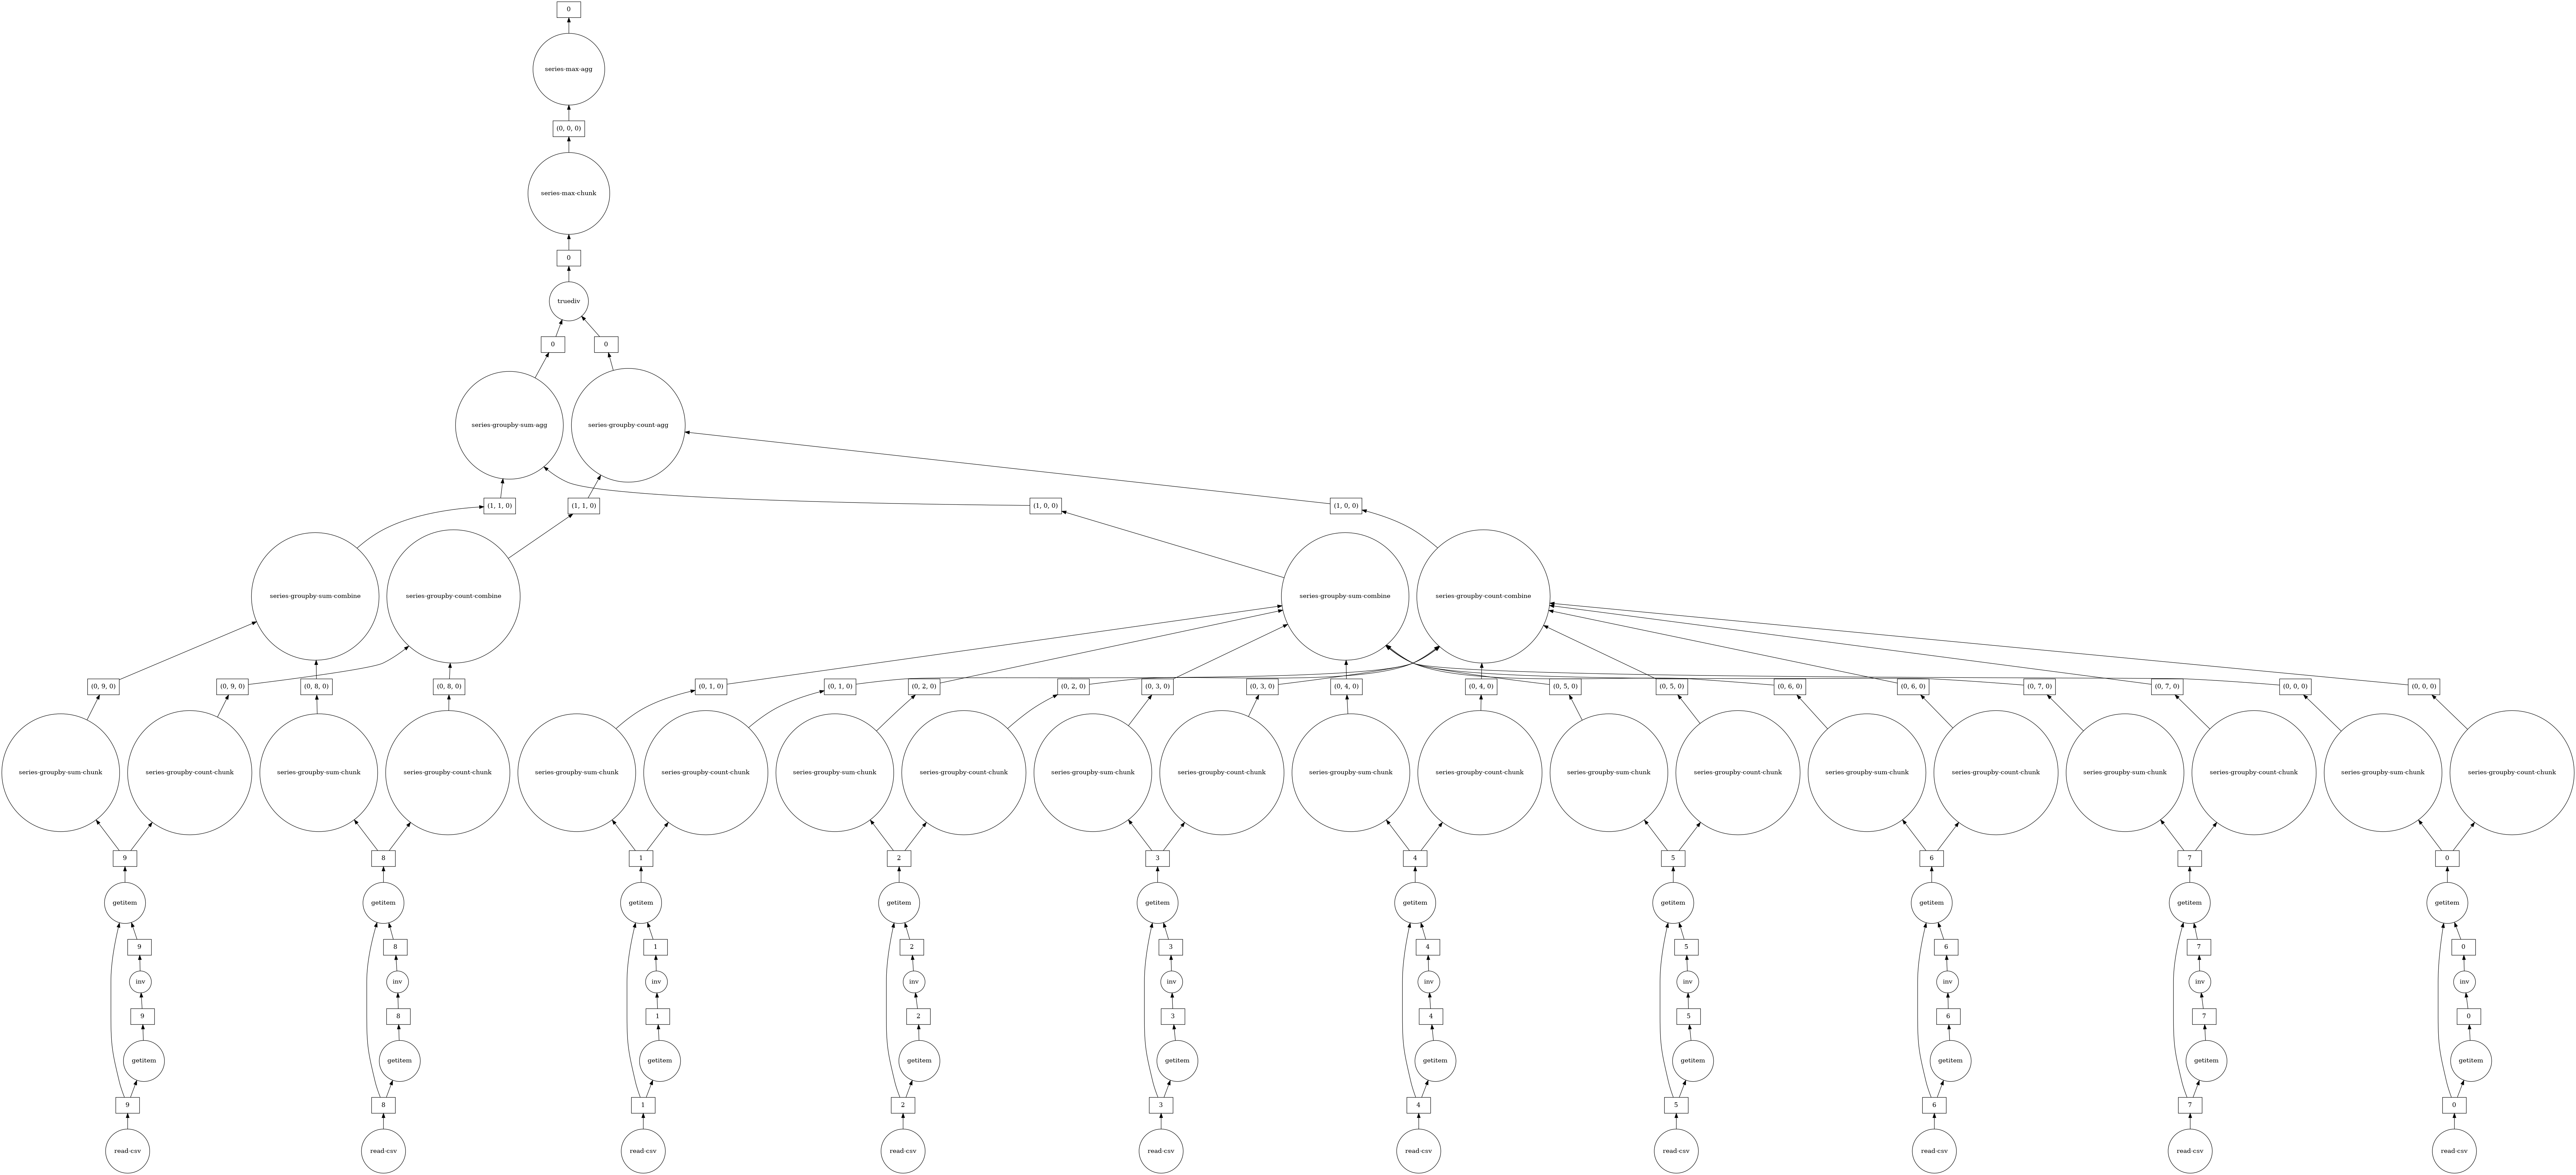

In [5]:
largest_delay.visualize()

#### **Making a distributed cluster:**
#### Simple method (deploy a distributed cluster locally):

The `dask.distributed` system is composed of a single centralized scheduler and one or more worker processes. [Deploying](https://docs.dask.org/en/latest/setup.html) a remote Dask cluster involves some additional effort. But doing things locally is just involves creating a `Client` object, which lets you interact with the "cluster" (local threads or processes on your machine). For more information see [here](https://docs.dask.org/en/latest/setup/single-distributed.html). 

Note that `Client()` takes a lot of optional [arguments](https://distributed.dask.org/en/latest/local-cluster.html#api), to configure the number of processes/threads, memory limits and other 

In [2]:
from dask.distributed import Client

# Setup a local cluster.
# By default this sets up 1 worker per core
client = Client()
client.cluster

Consider some trivial calculation, such as we've used before, where we have added sleep statements in order to simulate real work being done.

In [3]:
from dask import delayed

import time

def inc(x):
    time.sleep(5)
    return x + 1

def dec(x):
    time.sleep(3)
    return x - 1

def add(x, y):
    time.sleep(7)
    return x + y

By default, creating a Client makes it the default scheduler. Any calls to .compute will use the cluster your client is attached to, unless you specify otherwise, as abov

In [4]:
x = delayed(inc)(1)
y = delayed(dec)(2)
total = delayed(add)(x, y)
total.compute()

3

In [10]:
from dask.distributed import Client
c = Client(n_workers=4)
c.cluster

/srv/conda/envs/notebook/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35321 instead
  warnings.warn(


In [11]:
from dask.distributed import wait, progress

In [12]:
def inc(x):
    return x + 1

In [13]:
fut = c.submit(inc, 1)
fut

<Future: pending, key: inc-cc7508aa8fed9e5441f246540f476eb2>

In [14]:
progress(fut)

VBox()

In [15]:
wait(fut)

DoneAndNotDoneFutures(done={<Future: finished, type: builtins.int, key: inc-cc7508aa8fed9e5441f246540f476eb2>}, not_done=set())

In [16]:
c.gather(fut)

2

#### persist()

# **Debug**